In [1]:
#%load_ext autoreload
#%autoreload 2

import os
import sys
sys.path.append(os.path.abspath(".."))

import gym
import random
import argparse
import numpy as np

import torch
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch import FloatTensor as T

from src.agent import Agent
from src.utils import TrajStats, set_seeds, arr2var
from src.envs_wrappers import SubprocEnvs

In [2]:
def compute_kl(logits_1, logits_2):
    """
    Computes KL divergence between discrete distributions
    """
    probs_1 = F.softmax(logits_1, dim=-1)
    kl_components = probs_1 * (F.log_softmax(logits_1, dim=-1) - F.log_softmax(logits_2, dim=-1))
    return torch.mean(torch.sum(kl_components, dim=1))


def get_flat_params(model):
    return torch.cat([param.data.view(-1) for param in model.parameters()])


def set_flat_params(model, flat_params):
    ind_start = 0
    for param in model.parameters():
        ind_end = ind_start + np.prod(param.shape)
        param.data.copy_(flat_params[ind_start : ind_end].view(param.shape))
        ind_start = ind_end
        
def set_flat_grads(model, flat_grads):
    ind_start = 0
    for param in model.parameters():
        ind_end = ind_start + np.prod(param.shape)
        param.grad = flat_grads[ind_start : ind_end].view(param.shape)
        ind_start = ind_end
        
def get_flat_grads(model, loss, support_next_order=False):
    """
    Walkaround for computing grads in case loss does not depend on some leafs
    TODO: remove `try` later
    """
    
    if support_next_order:
        grads = []
        for param in model.parameters():
            try:
                grads.append(torch.autograd.grad(loss, param, create_graph=True)[0])
            except RuntimeError:
                grads.append(Variable(torch.zeros_like(param.data)))
    else:
        for p in model.parameters():
            p.grad = None

        loss.backward(retain_graph=True)
        grads = [p.grad if p.grad is not None else Variable(torch.zeros_like(p.data))
                 for p in model.parameters()]
        
    return torch.cat([grad.view(-1) for grad in grads])
        
def cg(matvec, b, cg_iters=10, residual_tol=1e-10):
    """
    Solves system Ax=b via conjugate gradients method.
    Adapted from John Schulman's code:
    https://github.com/joschu/modular_rl/blob/master/modular_rl/trpo.py
    Arguments:
        matvec        --  matrix-vector product function
        b             --  right-hand side
        cg_iters      --  number of iterations
        residual_tol  --  tolerance
    """
    
    x = torch.zeros(b.size())
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)
    
    for i in range(cg_iters):
        Ap = matvec(p)
        alpha = rdotr / torch.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        newrdotr = torch.dot(r, r)
        beta = newrdotr / rdotr
        p = r + beta * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
            
    return x

def linesearch(f, x, fullstep, expected_improve_rate, max_backtracks=10, accept_ratio=.05):
    """
    Backtracking linesearch for finding optimal proposed step size.
    Adapted from John Schulman's code:
    https://github.com/joschu/modular_rl/blob/master/modular_rl/trpo.py
    Arguments:
        f                      --  
        x                      --  
        fullstep               --  
        expected_improve_rate  --  
        max_backtracks         --
        accept_ratio           --
    """
    fval = f(x)
    x_best = None
    max_ratio = -1
    for stepfrac in .5**np.arange(max_backtracks):
        xnew = x + stepfrac*fullstep
        newfval = f(xnew)
        actual_improve = (newfval - fval).data[0]
        if actual_improve > 0:
            expected_improve = expected_improve_rate * stepfrac
            ratio = actual_improve / expected_improve
            if ratio > accept_ratio and ratio > max_ratio:
                max_ratio = ratio
                x_best = xnew
        
    return (True, x_best) if x_best is not None else (False, x) 


def hess_vec_full(vec, model, grads, damping):
    grads_vec = torch.dot(grads, Variable(vec))
    res = get_flat_grads(model, grads_vec).data

    return res + damping * vec


def compute_obj_full(flat_params, agent, tss, gamma, lambda_gae):
    # TODO: rewrite without new TrajStats 
    # TODO: and probably rewrite TrajStats, e.g. append to dict, make calc_gae not a method of class
    
    set_flat_params(agent, flat_params)
    
    res = 0
    
    for ts in tss:
        cur_ts = TrajStats()
        cur_ts.rewards = ts.rewards
        cur_ts.states = ts.states
        cur_ts.actions = ts.actions
        
        cur_ts.logits, cur_ts.values = agent.forward(cur_ts.states)
        cur_ts.values = [v for v in cur_ts.values]
        cur_ts.logs_pi_a = F.log_softmax(cur_ts.logits, dim=-1)[np.arange(len(cur_ts.actions)), 
                                                                np.array(cur_ts.actions)]
        cur_ts.logs_pi_a = [l for l in cur_ts.logs_pi_a]
        
        advantages = cur_ts.calc_gaes(gamma, lambda_gae)
        #advantages = cur_ts.calc_advs(gamma, n_step=1)
        old_logs_pi = ts.get_logs_pi_a()
        logs_pi = cur_ts.get_logs_pi_a()
        res += (torch.exp(logs_pi - old_logs_pi) * advantages.detach()).sum()
    
    return res / len(tss)

def check_vol():
    return len(list(filter(lambda x: x.volatile, list(agent.parameters())))) == 0

def get_flat_grads_without_try(model, loss):
    """
    temporary, remove it later
    """
    
    grads = []
    for name, param in model.named_parameters():
        grads.append(torch.autograd.grad(loss, param, create_graph=True)[0])
            
    return torch.cat([grad.view(-1) for grad in grads])

In [3]:
cg_damping = 1e-3
max_kl = 1e-2
global crl
global entr_l
global acl 
global returns_l
crl = []
entr_l = []
acl = []
returns_l = []

In [10]:
def learn(agent, envs, update_rule, n_timesteps=1e5, gamma=0.99, lambda_gae=0.99, entr_coef=1e-3, log_interval=1e4):
    """
    Optimize networks parameters via interacting with env
    Arguments:
        agent           --  agent to optimize
        envs            --  list of environments to interact with
        update_rule     --  'A2C', 'TRPO' or 'K-FAC', str
        n_timesteps     --  number of interactions with environments, int
        lambda_gae      --  mixing coefficient in generalized advantage estimation
        entr_coef       --  entropy loss multiplier, float
        log_interval    --  number of timesteps to print debug info, int
    """
    ENTR_C = 0#1e1
    global returns_l
    returns_l = []
    
    n_envs = len(envs)
    w_envs = SubprocEnvs(envs)

    agent.train()
    returns = []
    timestep = 0
    timestep_diff = 0
    
    if update_rule == 'A2C':
        optimizer = optim.Adam(agent.parameters(), lr=1e-3)
    elif update_rule == 'TRPO':
        optimizer = optim.Adam(agent.net.value_head.parameters())
    elif update_tule == 'K-FAC':
        raise NotImplementedError
        optimizer = KFACOptimizer(agent.parameters())
    else:
        raise ValueError('Unknown update rule')

    while timestep < n_timesteps:
        states = w_envs.reset()
        tss = [TrajStats() for _ in range(n_envs)]

        while w_envs.has_alive_envs():
            logits, value = agent.forward(states)
            actions = agent.sample_action(logits)

            ind_alive = w_envs.get_indices_alive()
            states_new, rewards, done, _ = w_envs.step(actions)      
            
            for i, i_alive in enumerate(ind_alive):
                tss[i_alive].append(rewards[i], F.log_softmax(logits[i], dim=-1)[actions[i]], value[i], logits[i], states[i], actions[i])
            states = states_new[np.logical_not(done)]

            timestep_diff += len(ind_alive)
            timestep += len(ind_alive)
            if timestep_diff >= log_interval:
                ENTR_C *= 0.75
                timestep_diff -= log_interval
                print('{} timesteps, av. return: {:.3f}'.format((timestep // log_interval) * log_interval, 
                                                                np.mean(returns[-300:])))
        critic_loss = 0
        actor_loss = 0
        entr = 0
        for ts in tss:
            episode_returns = ts.calc_episode_returns(gamma)
            critic_loss += 0.5*(ts.get_values() - episode_returns).pow(2).sum()
            returns.append(ts.calc_return(gamma))
            returns_l.append(returns[-1])
            
            advantages = ts.calc_gaes(gamma, lambda_gae)
            logs_pi = ts.get_logs_pi_a()
            
            logits = ts.get_logits()
            p = F.softmax(logits, dim=1)
            entr += -(p * torch.log(p)).sum()
            #entr += -(logs_pi * torch.exp(logs_pi)).sum()
            
            actor_loss += -(logs_pi * advantages.detach()).sum()  # minus added in order to ascend

        global crl
        global entr_l
        global acl 
        crl.append(critic_loss.data[0])
        entr_l.append(entr.data[0])
        acl.append(actor_loss.data[0])
        
        optimizer.zero_grad()
        
        if update_rule == 'A2C' or update_rule == 'K-FAC':
            #print (actor_loss, critic_loss, entr)
            ((actor_loss + critic_loss - ENTR_C * entr) / n_envs).backward()
            optimizer.step()
        elif update_rule == 'TRPO':
            
            critic_flat_grads = get_flat_grads(agent, critic_loss/n_envs)
            flat_grads = get_flat_grads(agent, (actor_loss - ENTR_C * entr) ).data
            
            if np.allclose(flat_grads.numpy(), 0):
                print('zero gradients, passing')
                continue

            kl = 0
            for ts in tss:
                logits = ts.get_logits()
                kl += compute_kl(logits, logits.detach())

            flat_grads_kl = get_flat_grads(agent, kl, support_next_order=True)
            hess_vec = lambda vec: hess_vec_full(vec, agent, flat_grads_kl, cg_damping)

            stepdir = cg(hess_vec, -flat_grads, cg_iters=10)
            shs = 0.5 * torch.dot(stepdir, hess_vec(stepdir))
            
            lm = np.sqrt(shs / max_kl)
            proposed_step = stepdir / lm
            neggdotstepdir = torch.dot(-flat_grads, stepdir)

            compute_obj = lambda flat_params: compute_obj_full(flat_params, agent, tss, gamma, lambda_gae)
            params_prev = get_flat_params(agent)
            success, params_new = linesearch(compute_obj, params_prev, proposed_step, neggdotstepdir / lm)
            set_flat_params(agent, params_new)

            set_flat_grads(agent, critic_flat_grads)
            optimizer.step()
        
    w_envs.close()

In [11]:
n_timesteps = 200000
gamma = 0.99
log_interval = 5000
batch_size = 1
lambda_gae = 0.99

#env = 'CartPole-v1'
env = 'FrozenLake-v0'
envs = [gym.make(env) for _ in range(batch_size)]
set_seeds(envs, 0, False)

agent = Agent(envs[0].observation_space, envs[0].action_space)
update_rule = 'TRPO'

learn(agent, envs, update_rule, n_timesteps=n_timesteps, gamma=gamma, 
      lambda_gae=lambda_gae, log_interval=log_interval)

/Users/ykemaev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in double_scalars
/Users/ykemaev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in sqrt


ZeroDivisionError: float division by zero

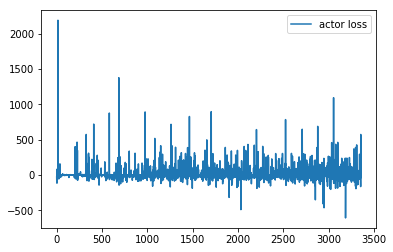

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

window_size = 50
#plt.plot(np.convolve(returns_l, np.ones(window_size) / window_size, mode='valid'))
#plt.plot(crl[::2], label='critic')
#plt.plot(entr_l[::2], label='entropy')
plt.plot(acl[::2], label='actor loss')
plt.legend()

In [ ]:
            # TEST
            if False:
                for p in agent.parameters():
                    p.grad = None
                actor_loss.backward()
                grads = torch.cat([ 
                    p.grad.data.view(-1) 
                    for p in agent.parameters() if p.grad is not None
                ])
                
                print (grads.size())
                print (flat_grads.size())
                print (grads)
                print (flat_grads)
                return -1